In [1]:
import sys
import os
import glob
from pathlib import Path
import random
import time
import datetime
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
import re
import transformers
import torch 
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
%matplotlib inline
sns.set_theme(style='darkgrid')

In [2]:
from pkg.UTHBERT.preprocess_text import preprocess as my_preprocess
from pkg.UTHBERT.tokenization_mod import MecabTokenizer, FullTokenizerForMecab
from transformers import BertModel,BertConfig

In [3]:
def get_device() -> str:
    """
    Returns the best available device for PyTorch computations.
    """
    if torch.backends.mps.is_available():
        # macOS with Apple Silicon (MPS backend)
        return "mps"
    elif torch.cuda.is_available():
        # NVIDIA GPU
        return "cuda"
    else:
        # Fallback to CPU
        return "cpu"

try:
    device = torch.device(get_device())
    print(f"Using device: {device}")
except RuntimeError as e:
    print(f"Failed to initialize the device: {e}")
    device = torch.device("cpu")  # Fallback to CPU in case of an error

Using device: mps


In [4]:
seed=0
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False #Trueで高速化重視, Falseで再現性重視
seed_everything(seed)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.use_deterministic_algorithms(True)
torch.set_num_threads(1)

# Tokenizer

In [5]:
dic_path = './dic'

In [6]:
# special token for a Person's name (Do not change)
name_token = "＠＠Ｎ"

# path to the mecab-ipadic-neologd
mecab_ipadic_neologd = dic_path + '/mecab-ipadic-neologd'

# path to the J-Medic (We used MANBYO_201907_Dic-utf8.dic)
mecab_J_medic = dic_path + '/MANBYO/MANBYO_201907_Dic-utf8.dic'

# path to the uth-bert vocabulary
vocab_file = dic_path + '/UTH-BERT/bert_vocab_mc_v1_25000.txt'

In [7]:
# MecabTokenizer
sub_tokenizer = MecabTokenizer(mecab_ipadic_neologd=mecab_ipadic_neologd,
                               mecab_J_medic=mecab_J_medic,
                               name_token=name_token)

# FullTokenizerForMecab
tokenizer = FullTokenizerForMecab(sub_tokenizer=sub_tokenizer,
                                  vocab_file=vocab_file,
                                  do_lower_case=False)

In [8]:
def tokenize(sentence_list):
    token_list = []
    for s in tqdm(sentence_list):
        tokens = tokenizer.tokenize(my_preprocess(str(s)))
        ids = tokenizer.convert_tokens_to_ids(tokens)
        ids = [2] + ids + [3]
        token_list.append(ids)
    return token_list

# Data

In [9]:
def create_dataframe(folder_path):
    """
    指定されたフォルダ内のテキストファイルからDataFrameを作成する関数

    Args:
        folder_path (str): テキストファイルが入っているフォルダのパス

    Returns:
        pandas.DataFrame: 作成されたDataFrame
    """

    # フォルダ内のすべてのテキストファイルのパスを取得
    file_list = glob.glob(folder_path + "/*.txt")

    # 空のDataFrameを作成
    df_text = pd.DataFrame(columns=['id', 'text'])
    
    # label.csvを読み込む
    df_label = pd.read_csv(os.path.join(folder_path, "label.csv"))

    for file in file_list:
        # ファイル名からIDを抽出
        file_id = file.split("/")[-1].split(".")[0]
        # file_id = file.split("\\")[-1].split(".")[0] # Windows
        
        # テキストファイルを読み込む
        with open(file, 'r', encoding='utf-8') as f:
            text = f.read()

        # DataFrameに追記
        rows = []
        rows.append({'id': int(file_id), 'text': text})
        df_text = pd.concat([df_text, pd.DataFrame(rows)], ignore_index=True)
        
    # textとlabelのDataFrameを結合
    df = pd.merge(df_text, df_label, on='id', how='left')

    return df

train_folder_path = "../../radnlp_2024_train_val_20240731/ja/main_task/train"
train_df = create_dataframe(train_folder_path)
val_folder_path = "../../radnlp_2024_train_val_20240731/ja/main_task/val"
val_df = create_dataframe(val_folder_path)

In [10]:
train_df

,id,text,t,n,m
0,4166189,左肺上葉に長径 12cm の腫瘤を認めます。弓部大動脈や肺動脈浸潤が疑われます。\nT4 と...,T4,N2,M0
1,1185427,右下葉に長径 30mm 大の腫瘤を認め、肺癌を疑います。葉間胸膜の陥入を伴い、臓\n側胸膜浸...,T1c,N0,M0
2,165742,右肺尖部に長径 5 ㎝の腫瘤を認めます。辺縁に棘状影が見られ原発性肺癌を疑いま\nす。壁側胸...,T3,N0,M0
3,6848850,両側肺野に肺気腫を認めます。\n右肺下葉に分葉状腫瘤性病変を認めます（最大径 37×37×4...,T2a,N2,M1c
4,9818606,肺野背景に気腫性変化を認めます。\n右肺下葉に長径 40mm の腫瘤を認めます。分葉状の形態...,T2a,N2,M1c
...,...,...,...,...,...
103,15410359,比較可能な画像検査はありません。\n右肺尖部に長径 50mm 大の腫瘤影を認めます。病変は...,T2b,N0,M0
104,8602016,右肺門部に軟部影を認め、ご指摘の悪性腫瘍が疑われます。右下葉は無気肺となっ\nています。\n...,T2a,N3,M0
105,1876861,肺野は背景に慢性肺気腫の所見を認めます。\n右肺尖部に⻑径 48mm の不整形腫瘤を認め、原...,T2b,N2,M1b
106,13567317,背景に間質性肺炎、肺気腫を疑います。気腫合併肺線維症のような肺癌の発生しや\nすい状態を疑い...,T2b,N2,M0


In [11]:
print(train_df['t'].value_counts())
print(train_df['n'].value_counts())
print(train_df['m'].value_counts())

t
T4     31
T2a    20
T2b    19
T3     18
T1b     9
T1c     8
T0      3
Name: count, dtype: int64
n
N2    45
N0    41
N1    13
N3     9
Name: count, dtype: int64
m
M0     74
M1c    20
M1b    14
Name: count, dtype: int64


In [12]:
add_df = pd.read_csv("../add_data.csv", encoding = 'cp932')

In [13]:
add_df

,id,text,t,n,m
0,0,原発腫瘍を認めない,T0,N0,M0
1,1,上皮内癌（carcinoma in situ）：肺野型の場合は、充実成分径0cmかつ病変全体...,Tis,N0,M0
2,2,微少浸潤性腺癌：部分充実型を示し、充実成分径≦0.5cmかつ病変全体径≦3cm。かつ肺または...,T1mi,N0,M0
3,3,腫瘍の充実成分径≦1cmでかつTis・T1miには相当しない。かつ肺または臓側胸膜に覆われて...,T1a,N0,M0
4,4,腫瘍の充実成分径>1cmでかつ≦2cm。かつ肺または臓側胸膜に覆われている。かつ葉気管支より...,T1b,N0,M0
5,5,腫瘍の充実成分径>2cmでかつ≦3cm。かつ肺または臓側胸膜に覆われている。かつ葉気管支より...,T1c,N0,M0
6,6,腫瘍の充実成分径>3cmでかつ≦4cm。または充実成分径≦3cmでも以下のいずれかであるもの...,T2a,N0,M0
7,7,腫瘍の充実成分径>4cmでかつ≦5cm。または充実成分径≦3cmでも以下のいずれかであるもの...,T2b,N0,M0
8,8,充実成分径>5cmでかつ≦7cm。または充実成分径≦5cmでも以下のいずれかであるもの：壁側...,T3,N0,M0
9,9,充実成分径＞7cm、または大きさを問わず横隔膜、縦隔、心臓、大血管、気管、反回神経、食道、椎...,T4,N0,M0


In [14]:
# 訓練データを追加する
df_train = pd.concat([add_df, train_df])

In [15]:
df_train

,id,text,t,n,m
0,0,原発腫瘍を認めない,T0,N0,M0
1,1,上皮内癌（carcinoma in situ）：肺野型の場合は、充実成分径0cmかつ病変全体...,Tis,N0,M0
2,2,微少浸潤性腺癌：部分充実型を示し、充実成分径≦0.5cmかつ病変全体径≦3cm。かつ肺または...,T1mi,N0,M0
3,3,腫瘍の充実成分径≦1cmでかつTis・T1miには相当しない。かつ肺または臓側胸膜に覆われて...,T1a,N0,M0
4,4,腫瘍の充実成分径>1cmでかつ≦2cm。かつ肺または臓側胸膜に覆われている。かつ葉気管支より...,T1b,N0,M0
...,...,...,...,...,...
103,15410359,比較可能な画像検査はありません。\n右肺尖部に長径 50mm 大の腫瘤影を認めます。病変は...,T2b,N0,M0
104,8602016,右肺門部に軟部影を認め、ご指摘の悪性腫瘍が疑われます。右下葉は無気肺となっ\nています。\n...,T2a,N3,M0
105,1876861,肺野は背景に慢性肺気腫の所見を認めます。\n右肺尖部に⻑径 48mm の不整形腫瘤を認め、原...,T2b,N2,M1b
106,13567317,背景に間質性肺炎、肺気腫を疑います。気腫合併肺線維症のような肺癌の発生しや\nすい状態を疑い...,T2b,N2,M0


In [16]:
X_train, X_valid = tokenize(train_df['text'].values.tolist()), tokenize(val_df['text'].values.tolist())

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

In [17]:
def convert_list(text_list, label_dic):
    """
    リストのテキストを、指定された辞書に基づいて数値に変換します。

    Args:
        text_list (list): 変換したいテキストのリスト
        label_dic (dict): テキストと対応する数値の辞書

    Returns:
        list: 数値に変換されたリスト
    """

    num_list = []
    for text in text_list:
        # 辞書から対応する数値を取得
        num = label_dic.get(text, None)
        if num is not None:
            num_list.append(num)
        else:
            print(f"対応する数値が見つかりません: {text}")
    return num_list

label_dic_t = {'T0':0, 'Tis':1, 'T1mi':2, 'T1a':3, 'T1b':4, 'T1c':5, 'T2a':6, 'T2b':7, 'T3':8, 'T4':9}
Yt_train, Yt_valid = convert_list(train_df['t'].values.tolist(), label_dic_t), convert_list(val_df['t'].values.tolist(), label_dic_t)

label_dic_n = {'N0':0, 'N1':1, 'N2':2, 'N3':3}
Yn_train, Yn_valid = convert_list(train_df['n'].values.tolist(), label_dic_n), convert_list(val_df['n'].values.tolist(), label_dic_n)

label_dic_m = {'M0':0, 'M1a':1, 'M1b':2, 'M1c':3}
Ym_train, Ym_valid = convert_list(train_df['m'].values.tolist(), label_dic_m), convert_list(val_df['m'].values.tolist(), label_dic_m)

# TNM各々分類モデルを学習

In [18]:
model_path = Path('./pkg/UTHBERT')
save_path = Path('./model')

In [19]:
num_classes_t=10
num_classes_n=4
num_classes_m=4

In [20]:
class MyCollator(object):
    '''
    Args:
    test : Set True when using with test data loader. Defaults to False
    percentile : Trim sequences by this percentile
    '''
    def __init__(self,test=False,percentile=100):
        self.test = test
        self.percentile = percentile
    def __call__(self, batch):
        if not self.test:
            data = [torch.tensor(item[0])  for item in batch]
            target = [item[1] for item in batch]
        else:
            data = [item for item in batch]
        
        # Padding
        data = pad_sequence(data, batch_first=True)
        data = data.clone().detach().long()
        masks = torch.where(data==0, 1, 0)
        masks = masks.clone().detach().long()
        if not self.test:
            target = torch.tensor(target, dtype=torch.long)
            return [data, masks, target]
        return [data, masks]

In [21]:
def build_data(train_data, valid_data, batch_size=8): 
        
    collate = MyCollator(percentile=100)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate) 
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate) 
     
    return train_loader, valid_loader

In [22]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)

class Net(nn.Module):
    def __init__(self, bert, num_classes):
        super(Net, self).__init__()
        self.bert = bert
        self.cls = nn.Linear(768, num_classes)

  # @torch.cuda.amp.autocast()
    def forward(self, inputs_ids, pad_masks, Attention=False):
        bout = self.bert(inputs_ids, pad_masks, output_attentions=Attention)
        bs = len(bout[0])
        h0 = [bout[0][i][0] for i in range(bs)]
        h0 = torch.stack(h0,dim=0)
        if Attention:
            return self.cls(h0),bout
        else:
            return self.cls(h0)

In [23]:
def plot_loss(train_loss, valid_loss):
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train_loss', 'valid_loss'], loc='upper right')
    plt.xticks(np.arange(0, epochs + 1, 5))
    plt.show()

In [24]:
def plot_metrics(train_acc, test_acc, test_f1):
    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.plot(test_f1)
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train_acc', 'valid_acc', 'valid_F1'], loc='lower right')
    plt.xticks(np.arange(0, epochs + 1, 5))
    plt.show()

In [25]:
def macro_average_f1(label_list, pred_list):
    return f1_score(label_list, pred_list, average='macro')

In [26]:
def synchronize():
    if torch.backends.mps.is_available():
        torch.mps.synchronize()
    elif torch.cuda.is_available():
        torch.cuda.synchronize()

def run(train_loader, valid_loader, model, num_classes, epochs=10, patience=5, delta=0.0, save_path=save_path):
    
    train_loss, valid_loss, train_acc, valid_acc, valid_f1 = [], [], [], [], []
    best_f1, best_acc = 0.0, 0.0
    best_f1_epoch, best_acc_epoch = 0, 0
    best_valid_loss = np.inf
    patience_counter = 0
    
    for epoch in range(0, epochs): 
        print(f'\nEpoch {epoch + 1}/{epochs}')
        print('-' * 10)
        epoch_train_loss, epoch_valid_loss = 0.0, 0.0
        epoch_train_acc = 0.0

        model.train() 
        start = time.time()
        for data in tqdm(train_loader): 
            inputs, masks, labels = data[0].to(device), data[1].to(device), data[2].to(device)
            optimizer.zero_grad() 
            outputs = model(inputs, masks)
            loss = criterion(outputs, labels)  
            loss.backward() 
            optimizer.step() 
            epoch_train_loss += loss.item() / len(train_loader) 
            acc = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
            epoch_train_acc += acc.item() / len(train_loader)
            del inputs, masks, labels, outputs, loss    

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        synchronize()
        elapsed_time = time.time() - start
        print(f'Train loss: {epoch_train_loss:.4f}, Train acc: {epoch_train_acc:.4f}, Time: {elapsed_time:.0f}s')
        
        model.eval()
        label_li, pred_li = [], []
        with torch.no_grad():
            for data in valid_loader:
                inputs, masks, labels = data[0].to(device), data[1].to(device), data[2].to(device)
                outputs = model(inputs, masks)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item() / len(valid_loader)
                preds = F.softmax(outputs, dim=1).argmax(dim=1)
                label_li.extend(labels.cpu().numpy())
                pred_li.extend(preds.cpu().numpy())

        valid_loss.append(epoch_valid_loss)
        epoch_valid_acc = accuracy_score(label_li, pred_li)
        epoch_valid_f1 = macro_average_f1(label_li, pred_li)
        valid_acc.append(epoch_valid_acc)
        valid_f1.append(epoch_valid_f1)

        print(f'Valid loss: {epoch_valid_loss:.4f}, Valid acc: {epoch_valid_acc:.4f}, Valid F1: {epoch_valid_f1:.4f}')

        if epoch_valid_acc > best_acc: 
            best_acc = epoch_valid_acc
            best_acc_epoch = epoch
            torch.save(model.state_dict(), save_path / f'best_acc_2.pth')
        if epoch_valid_f1 > best_f1: 
            best_f1 = epoch_valid_f1
            best_f1_epoch = epoch
            torch.save(model.state_dict(), save_path / f'best_f1_2.pth')

        # # Early stopping
        # if epoch_valid_loss < best_valid_loss - delta:
        #     best_valid_loss = epoch_valid_loss
        #     patience_counter = 0  # 改善があったので、カウンタをリセット
        # else:
        #     patience_counter += 1
        # if patience_counter >= patience:
        #     print(f'Early stopping at epoch {epoch + 1}')
        #     break
            
    print('\nTraining complete')
    print(f'Best ACC: {best_acc:.4f} at epoch {best_acc_epoch}')
    print(f'Best F1: {best_f1:.4f} at epoch {best_f1_epoch}')

    return train_loss, valid_loss, train_acc, valid_acc, valid_f1 

## T分類モデル

In [27]:
batch_size=2
epochs=50
learning_rate=1e-5
momentum=0.9

In [28]:
train_data = []
valid_data = []
for x, y in zip(X_train, Yt_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Yt_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [29]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes_t).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [30]:
train_loss, valid_loss, train_acc, valid_acc, valid_f1 = run(train_loader, valid_loader, model,
                                                             num_classes_t, epochs=epochs,
                                                             save_path=save_path/'t')


Epoch 1/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 2.0800, Train acc: 0.2315, Time: 22s
Valid loss: 2.3314, Valid acc: 0.3333, Valid F1: 0.0682

Epoch 2/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.9187, Train acc: 0.1852, Time: 13s
Valid loss: 2.3306, Valid acc: 0.2037, Valid F1: 0.0657

Epoch 3/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.8283, Train acc: 0.2407, Time: 11s
Valid loss: 2.2399, Valid acc: 0.2407, Valid F1: 0.0792

Epoch 4/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.8303, Train acc: 0.2222, Time: 11s
Valid loss: 2.3011, Valid acc: 0.2593, Valid F1: 0.0863

Epoch 5/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.7535, Train acc: 0.3148, Time: 10s
Valid loss: 2.3093, Valid acc: 0.1667, Valid F1: 0.0755

Epoch 6/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.7498, Train acc: 0.3426, Time: 11s
Valid loss: 2.1585, Valid acc: 0.3333, Valid F1: 0.0662

Epoch 7/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6476, Train acc: 0.3611, Time: 10s
Valid loss: 2.3157, Valid acc: 0.3148, Valid F1: 0.0946

Epoch 8/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6999, Train acc: 0.3426, Time: 10s
Valid loss: 2.4012, Valid acc: 0.2037, Valid F1: 0.0861

Epoch 9/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.5851, Train acc: 0.3889, Time: 10s
Valid loss: 2.2990, Valid acc: 0.2778, Valid F1: 0.0575

Epoch 10/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.4962, Train acc: 0.4352, Time: 10s
Valid loss: 2.4868, Valid acc: 0.2963, Valid F1: 0.1000

Epoch 11/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6467, Train acc: 0.3704, Time: 10s
Valid loss: 2.1991, Valid acc: 0.3889, Valid F1: 0.1585

Epoch 12/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.5334, Train acc: 0.4352, Time: 10s
Valid loss: 2.2701, Valid acc: 0.3148, Valid F1: 0.0796

Epoch 13/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.5158, Train acc: 0.4722, Time: 10s
Valid loss: 2.4549, Valid acc: 0.2407, Valid F1: 0.1063

Epoch 14/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6202, Train acc: 0.4074, Time: 10s
Valid loss: 2.5034, Valid acc: 0.1667, Valid F1: 0.0585

Epoch 15/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6873, Train acc: 0.3333, Time: 10s
Valid loss: 2.3660, Valid acc: 0.3519, Valid F1: 0.1364

Epoch 16/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.5262, Train acc: 0.3889, Time: 10s
Valid loss: 2.4609, Valid acc: 0.3148, Valid F1: 0.1255

Epoch 17/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.5284, Train acc: 0.4259, Time: 10s
Valid loss: 2.6390, Valid acc: 0.3148, Valid F1: 0.0806

Epoch 18/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6532, Train acc: 0.3333, Time: 10s
Valid loss: 2.3572, Valid acc: 0.2778, Valid F1: 0.0636

Epoch 19/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6401, Train acc: 0.3519, Time: 10s
Valid loss: 2.4176, Valid acc: 0.3333, Valid F1: 0.0943

Epoch 20/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.4770, Train acc: 0.4074, Time: 10s
Valid loss: 2.4526, Valid acc: 0.2778, Valid F1: 0.0585

Epoch 21/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.4536, Train acc: 0.3981, Time: 10s
Valid loss: 2.6304, Valid acc: 0.3519, Valid F1: 0.1055

Epoch 22/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.5903, Train acc: 0.3426, Time: 10s
Valid loss: 2.7223, Valid acc: 0.3148, Valid F1: 0.0609

Epoch 23/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.4860, Train acc: 0.4074, Time: 10s
Valid loss: 2.3910, Valid acc: 0.3333, Valid F1: 0.0842

Epoch 24/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6006, Train acc: 0.3981, Time: 10s
Valid loss: 2.3223, Valid acc: 0.2963, Valid F1: 0.1390

Epoch 25/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.4440, Train acc: 0.4259, Time: 10s
Valid loss: 2.4523, Valid acc: 0.3519, Valid F1: 0.1469

Epoch 26/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.3263, Train acc: 0.4722, Time: 10s
Valid loss: 2.4510, Valid acc: 0.3704, Valid F1: 0.1995

Epoch 27/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.5472, Train acc: 0.4537, Time: 10s
Valid loss: 2.5954, Valid acc: 0.1667, Valid F1: 0.0895

Epoch 28/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.5069, Train acc: 0.4167, Time: 10s
Valid loss: 2.5344, Valid acc: 0.2222, Valid F1: 0.0796

Epoch 29/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.2521, Train acc: 0.5463, Time: 10s
Valid loss: 2.4748, Valid acc: 0.3519, Valid F1: 0.1228

Epoch 30/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.2731, Train acc: 0.6111, Time: 10s
Valid loss: 2.4290, Valid acc: 0.2407, Valid F1: 0.1066

Epoch 31/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.2772, Train acc: 0.4907, Time: 10s
Valid loss: 2.5304, Valid acc: 0.3333, Valid F1: 0.0982

Epoch 32/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.7430, Train acc: 0.3241, Time: 10s
Valid loss: 2.5432, Valid acc: 0.3333, Valid F1: 0.0625

Epoch 33/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.7557, Train acc: 0.3056, Time: 10s
Valid loss: 2.5331, Valid acc: 0.2222, Valid F1: 0.0838

Epoch 34/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.7476, Train acc: 0.3241, Time: 10s
Valid loss: 2.4396, Valid acc: 0.3148, Valid F1: 0.0616

Epoch 35/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.7574, Train acc: 0.3241, Time: 10s
Valid loss: 2.6539, Valid acc: 0.1296, Valid F1: 0.0469

Epoch 36/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.7665, Train acc: 0.2778, Time: 10s
Valid loss: 2.4251, Valid acc: 0.2778, Valid F1: 0.0885

Epoch 37/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.7447, Train acc: 0.2685, Time: 10s
Valid loss: 2.4958, Valid acc: 0.3704, Valid F1: 0.1118

Epoch 38/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6936, Train acc: 0.3148, Time: 10s
Valid loss: 2.5360, Valid acc: 0.3519, Valid F1: 0.1113

Epoch 39/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6989, Train acc: 0.3796, Time: 10s
Valid loss: 2.6017, Valid acc: 0.2963, Valid F1: 0.1026

Epoch 40/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6200, Train acc: 0.3704, Time: 10s
Valid loss: 2.7196, Valid acc: 0.3148, Valid F1: 0.0817

Epoch 41/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.7586, Train acc: 0.3056, Time: 10s
Valid loss: 2.5699, Valid acc: 0.3704, Valid F1: 0.1230

Epoch 42/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.7172, Train acc: 0.3796, Time: 10s
Valid loss: 2.6787, Valid acc: 0.3333, Valid F1: 0.0970

Epoch 43/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6912, Train acc: 0.3981, Time: 10s
Valid loss: 2.6134, Valid acc: 0.3519, Valid F1: 0.0853

Epoch 44/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6828, Train acc: 0.3056, Time: 10s
Valid loss: 2.5314, Valid acc: 0.3519, Valid F1: 0.0912

Epoch 45/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6467, Train acc: 0.3333, Time: 10s
Valid loss: 2.7008, Valid acc: 0.1111, Valid F1: 0.0417

Epoch 46/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6124, Train acc: 0.3796, Time: 10s
Valid loss: 2.7819, Valid acc: 0.3889, Valid F1: 0.1196

Epoch 47/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6569, Train acc: 0.3889, Time: 10s
Valid loss: 2.6546, Valid acc: 0.3519, Valid F1: 0.0912

Epoch 48/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.6481, Train acc: 0.3796, Time: 10s
Valid loss: 2.6843, Valid acc: 0.3333, Valid F1: 0.1235

Epoch 49/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.5485, Train acc: 0.4259, Time: 10s
Valid loss: 2.6498, Valid acc: 0.3519, Valid F1: 0.1275

Epoch 50/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.5741, Train acc: 0.4167, Time: 10s
Valid loss: 2.8733, Valid acc: 0.3519, Valid F1: 0.0977

Training complete
Best ACC: 0.3889 at epoch 10
Best F1: 0.1995 at epoch 25


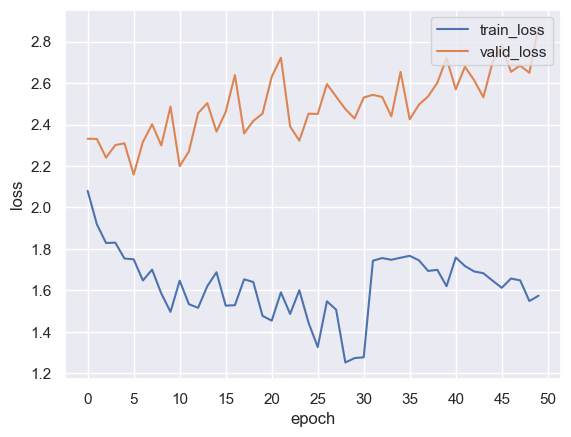

In [31]:
plot_loss(train_loss, valid_loss)

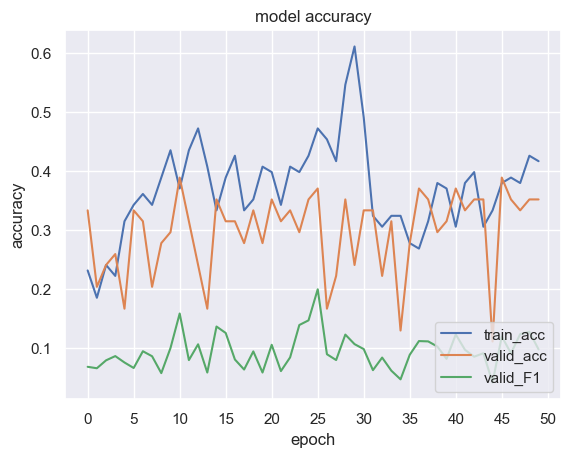

In [32]:
plot_metrics(train_acc, valid_acc, valid_f1)

In [33]:
print(f'accuracy: {max(valid_acc)}, f1 score: {max(valid_f1)}')

accuracy: 0.3888888888888889, f1 score: 0.19954369954369955


## N分類モデル

In [34]:
batch_size=2
epochs=50
learning_rate=1e-5
momentum=0.9

In [35]:
train_data = []
valid_data = []
for x, y in zip(X_train, Yn_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Yn_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [36]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes_n).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [37]:
train_loss, valid_loss, train_acc, valid_acc, valid_f1 = run(train_loader, valid_loader, model,
                                                             num_classes_n, epochs=epochs,
                                                             save_path=save_path/'n')


Epoch 1/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.2442, Train acc: 0.4074, Time: 10s
Valid loss: 1.1655, Valid acc: 0.3704, Valid F1: 0.1351

Epoch 2/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.2493, Train acc: 0.3611, Time: 10s
Valid loss: 1.0836, Valid acc: 0.5370, Valid F1: 0.2880

Epoch 3/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.2386, Train acc: 0.4167, Time: 10s
Valid loss: 1.0786, Valid acc: 0.5926, Valid F1: 0.3175

Epoch 4/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.1895, Train acc: 0.4907, Time: 10s
Valid loss: 1.0380, Valid acc: 0.6296, Valid F1: 0.3374

Epoch 5/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.1240, Train acc: 0.5463, Time: 10s
Valid loss: 1.0138, Valid acc: 0.6852, Valid F1: 0.3625

Epoch 6/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.1493, Train acc: 0.4352, Time: 10s
Valid loss: 1.1097, Valid acc: 0.5926, Valid F1: 0.3205

Epoch 7/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.0733, Train acc: 0.5278, Time: 10s
Valid loss: 1.2775, Valid acc: 0.2778, Valid F1: 0.1488

Epoch 8/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.1399, Train acc: 0.5185, Time: 10s
Valid loss: 0.9451, Valid acc: 0.5185, Valid F1: 0.2681

Epoch 9/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.0355, Train acc: 0.4722, Time: 10s
Valid loss: 0.9221, Valid acc: 0.7037, Valid F1: 0.3716

Epoch 10/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.9990, Train acc: 0.5093, Time: 10s
Valid loss: 1.2344, Valid acc: 0.5370, Valid F1: 0.2892

Epoch 11/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.0253, Train acc: 0.5463, Time: 10s
Valid loss: 0.8889, Valid acc: 0.7222, Valid F1: 0.3844

Epoch 12/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.9480, Train acc: 0.5741, Time: 10s
Valid loss: 0.9573, Valid acc: 0.5370, Valid F1: 0.2812

Epoch 13/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8931, Train acc: 0.6204, Time: 10s
Valid loss: 0.9953, Valid acc: 0.5556, Valid F1: 0.3000

Epoch 14/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.2157, Train acc: 0.4815, Time: 10s
Valid loss: 1.0551, Valid acc: 0.6111, Valid F1: 0.3299

Epoch 15/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.1902, Train acc: 0.4074, Time: 10s
Valid loss: 1.1743, Valid acc: 0.4444, Valid F1: 0.2400

Epoch 16/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.1462, Train acc: 0.4537, Time: 10s
Valid loss: 1.0519, Valid acc: 0.5000, Valid F1: 0.2545

Epoch 17/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.0736, Train acc: 0.5000, Time: 10s
Valid loss: 1.0402, Valid acc: 0.5370, Valid F1: 0.3231

Epoch 18/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.0460, Train acc: 0.5370, Time: 10s
Valid loss: 1.0892, Valid acc: 0.4444, Valid F1: 0.2095

Epoch 19/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.0901, Train acc: 0.5556, Time: 10s
Valid loss: 0.9610, Valid acc: 0.7222, Valid F1: 0.3855

Epoch 20/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.9147, Train acc: 0.6389, Time: 10s
Valid loss: 1.0824, Valid acc: 0.6111, Valid F1: 0.3323

Epoch 21/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.9246, Train acc: 0.5833, Time: 10s
Valid loss: 0.8858, Valid acc: 0.7037, Valid F1: 0.3708

Epoch 22/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.9068, Train acc: 0.5556, Time: 10s
Valid loss: 1.1318, Valid acc: 0.5556, Valid F1: 0.3391

Epoch 23/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.9366, Train acc: 0.5926, Time: 10s
Valid loss: 1.0167, Valid acc: 0.5926, Valid F1: 0.3250

Epoch 24/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8487, Train acc: 0.6019, Time: 10s
Valid loss: 1.0114, Valid acc: 0.6667, Valid F1: 0.3530

Epoch 25/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8377, Train acc: 0.5926, Time: 10s
Valid loss: 1.0181, Valid acc: 0.6481, Valid F1: 0.3549

Epoch 26/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.9281, Train acc: 0.5278, Time: 10s
Valid loss: 1.0847, Valid acc: 0.4815, Valid F1: 0.2457

Epoch 27/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8661, Train acc: 0.6111, Time: 10s
Valid loss: 1.2659, Valid acc: 0.3519, Valid F1: 0.2380

Epoch 28/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8572, Train acc: 0.5648, Time: 10s
Valid loss: 1.0648, Valid acc: 0.6481, Valid F1: 0.3483

Epoch 29/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.9054, Train acc: 0.6111, Time: 10s
Valid loss: 0.8651, Valid acc: 0.6481, Valid F1: 0.3500

Epoch 30/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.0553, Train acc: 0.5370, Time: 9s
Valid loss: 1.0233, Valid acc: 0.6111, Valid F1: 0.3209

Epoch 31/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.9133, Train acc: 0.5833, Time: 10s
Valid loss: 1.1435, Valid acc: 0.6296, Valid F1: 0.3393

Epoch 32/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8689, Train acc: 0.6481, Time: 10s
Valid loss: 1.0005, Valid acc: 0.6667, Valid F1: 0.3556

Epoch 33/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.7975, Train acc: 0.6481, Time: 10s
Valid loss: 1.0486, Valid acc: 0.4444, Valid F1: 0.2314

Epoch 34/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 1.0198, Train acc: 0.5648, Time: 9s
Valid loss: 1.1919, Valid acc: 0.4815, Valid F1: 0.2462

Epoch 35/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8022, Train acc: 0.6667, Time: 9s
Valid loss: 0.9733, Valid acc: 0.7037, Valid F1: 0.3916

Epoch 36/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8025, Train acc: 0.5926, Time: 10s
Valid loss: 0.9553, Valid acc: 0.6667, Valid F1: 0.3653

Epoch 37/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8144, Train acc: 0.6481, Time: 10s
Valid loss: 1.1836, Valid acc: 0.6111, Valid F1: 0.3265

Epoch 38/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8203, Train acc: 0.6759, Time: 10s
Valid loss: 1.3616, Valid acc: 0.5741, Valid F1: 0.3156

Epoch 39/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8663, Train acc: 0.6574, Time: 10s
Valid loss: 1.0000, Valid acc: 0.6852, Valid F1: 0.3674

Epoch 40/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8275, Train acc: 0.6389, Time: 9s
Valid loss: 0.9678, Valid acc: 0.6111, Valid F1: 0.3780

Epoch 41/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8971, Train acc: 0.5926, Time: 10s
Valid loss: 0.9945, Valid acc: 0.6481, Valid F1: 0.3515

Epoch 42/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.7780, Train acc: 0.6296, Time: 9s
Valid loss: 0.8823, Valid acc: 0.7407, Valid F1: 0.4941

Epoch 43/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.7583, Train acc: 0.6574, Time: 10s
Valid loss: 1.4105, Valid acc: 0.5185, Valid F1: 0.2791

Epoch 44/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.7577, Train acc: 0.6759, Time: 10s
Valid loss: 1.1005, Valid acc: 0.6296, Valid F1: 0.3423

Epoch 45/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.7110, Train acc: 0.6481, Time: 10s
Valid loss: 0.9684, Valid acc: 0.5556, Valid F1: 0.2952

Epoch 46/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.6880, Train acc: 0.6389, Time: 9s
Valid loss: 0.9472, Valid acc: 0.5741, Valid F1: 0.3138

Epoch 47/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8042, Train acc: 0.6296, Time: 10s
Valid loss: 1.1489, Valid acc: 0.4630, Valid F1: 0.2320

Epoch 48/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8140, Train acc: 0.6111, Time: 9s
Valid loss: 1.0212, Valid acc: 0.6481, Valid F1: 0.3488

Epoch 49/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.9630, Train acc: 0.5926, Time: 9s
Valid loss: 0.9765, Valid acc: 0.5556, Valid F1: 0.2939

Epoch 50/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8179, Train acc: 0.6296, Time: 9s
Valid loss: 1.0430, Valid acc: 0.7037, Valid F1: 0.3778

Training complete
Best ACC: 0.7407 at epoch 41
Best F1: 0.4941 at epoch 41


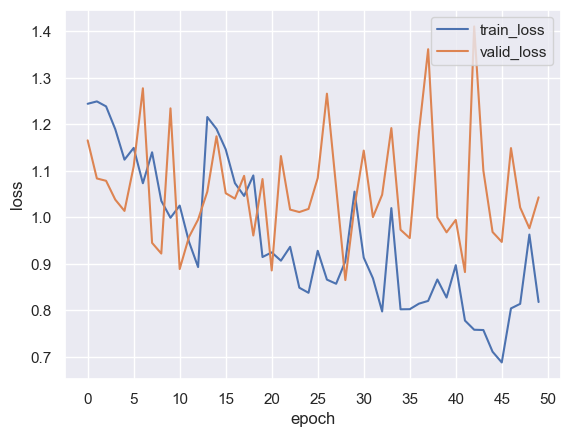

In [38]:
plot_loss(train_loss, valid_loss)

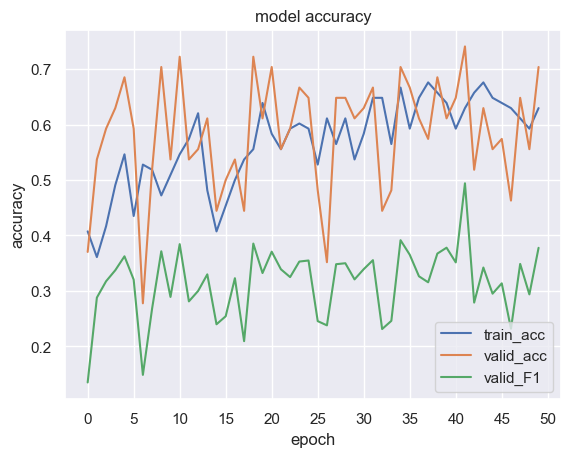

In [39]:
plot_metrics(train_acc, valid_acc, valid_f1)

In [40]:
print(f'accuracy: {max(valid_acc)}, f1 score: {max(valid_f1)}')

accuracy: 0.7407407407407407, f1 score: 0.49410722197607443


## M分類モデル

In [41]:
batch_size=2
epochs=50
learning_rate=1e-5
momentum=0.9

In [42]:
train_data = []
valid_data = []
for x, y in zip(X_train, Ym_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Ym_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [43]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes_m).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [44]:
train_loss, valid_loss, train_acc, valid_acc, valid_f1 = run(train_loader, valid_loader, model,
                                                             num_classes_m, epochs=epochs,
                                                             save_path=save_path/'m')


Epoch 1/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.9495, Train acc: 0.6759, Time: 10s
Valid loss: 1.6074, Valid acc: 0.5000, Valid F1: 0.2222

Epoch 2/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.8502, Train acc: 0.6944, Time: 10s
Valid loss: 1.4256, Valid acc: 0.5556, Valid F1: 0.3260

Epoch 3/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.7614, Train acc: 0.7407, Time: 10s
Valid loss: 1.3345, Valid acc: 0.6852, Valid F1: 0.4848

Epoch 4/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.7292, Train acc: 0.7685, Time: 10s
Valid loss: 1.5455, Valid acc: 0.5926, Valid F1: 0.3942

Epoch 5/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.6111, Train acc: 0.7593, Time: 10s
Valid loss: 1.6178, Valid acc: 0.4630, Valid F1: 0.2374

Epoch 6/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.6356, Train acc: 0.7593, Time: 10s
Valid loss: 1.8549, Valid acc: 0.6111, Valid F1: 0.3257

Epoch 7/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.6708, Train acc: 0.7500, Time: 9s
Valid loss: 1.6932, Valid acc: 0.6111, Valid F1: 0.3153

Epoch 8/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.5368, Train acc: 0.8056, Time: 10s
Valid loss: 1.5791, Valid acc: 0.6481, Valid F1: 0.4595

Epoch 9/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.5981, Train acc: 0.8056, Time: 10s
Valid loss: 1.7448, Valid acc: 0.6481, Valid F1: 0.3413

Epoch 10/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.5734, Train acc: 0.7963, Time: 9s
Valid loss: 1.5215, Valid acc: 0.7037, Valid F1: 0.3819

Epoch 11/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4476, Train acc: 0.8426, Time: 10s
Valid loss: 1.6484, Valid acc: 0.6667, Valid F1: 0.3636

Epoch 12/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4814, Train acc: 0.8333, Time: 9s
Valid loss: 1.8750, Valid acc: 0.5741, Valid F1: 0.3252

Epoch 13/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4485, Train acc: 0.8519, Time: 9s
Valid loss: 2.7833, Valid acc: 0.5000, Valid F1: 0.1688

Epoch 14/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.5912, Train acc: 0.7963, Time: 9s
Valid loss: 1.6173, Valid acc: 0.6296, Valid F1: 0.3431

Epoch 15/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.5030, Train acc: 0.8148, Time: 10s
Valid loss: 1.8481, Valid acc: 0.5741, Valid F1: 0.3550

Epoch 16/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.5420, Train acc: 0.8148, Time: 11s
Valid loss: 1.8291, Valid acc: 0.6111, Valid F1: 0.4067

Epoch 17/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4882, Train acc: 0.8611, Time: 10s
Valid loss: 1.7486, Valid acc: 0.6481, Valid F1: 0.4517

Epoch 18/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.6282, Train acc: 0.7870, Time: 10s
Valid loss: 1.7730, Valid acc: 0.5556, Valid F1: 0.2589

Epoch 19/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4893, Train acc: 0.8056, Time: 10s
Valid loss: 1.6156, Valid acc: 0.5926, Valid F1: 0.3184

Epoch 20/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4073, Train acc: 0.8519, Time: 10s
Valid loss: 2.2544, Valid acc: 0.5741, Valid F1: 0.2685

Epoch 21/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4152, Train acc: 0.8611, Time: 10s
Valid loss: 1.7878, Valid acc: 0.6296, Valid F1: 0.3450

Epoch 22/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.3745, Train acc: 0.8704, Time: 10s
Valid loss: 1.9877, Valid acc: 0.5926, Valid F1: 0.3818

Epoch 23/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.6243, Train acc: 0.7593, Time: 10s
Valid loss: 1.6445, Valid acc: 0.6481, Valid F1: 0.4618

Epoch 24/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4667, Train acc: 0.8796, Time: 10s
Valid loss: 1.9055, Valid acc: 0.5926, Valid F1: 0.3043

Epoch 25/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4319, Train acc: 0.8611, Time: 10s
Valid loss: 1.8159, Valid acc: 0.5370, Valid F1: 0.2905

Epoch 26/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.3841, Train acc: 0.8704, Time: 10s
Valid loss: 2.0311, Valid acc: 0.5370, Valid F1: 0.3071

Epoch 27/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.3937, Train acc: 0.8704, Time: 10s
Valid loss: 2.0742, Valid acc: 0.6111, Valid F1: 0.3151

Epoch 28/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.3897, Train acc: 0.8611, Time: 10s
Valid loss: 2.1079, Valid acc: 0.5556, Valid F1: 0.2821

Epoch 29/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4487, Train acc: 0.8519, Time: 10s
Valid loss: 1.7872, Valid acc: 0.6481, Valid F1: 0.4517

Epoch 30/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4172, Train acc: 0.8333, Time: 10s
Valid loss: 2.1048, Valid acc: 0.5741, Valid F1: 0.3167

Epoch 31/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4844, Train acc: 0.7963, Time: 9s
Valid loss: 2.3702, Valid acc: 0.5000, Valid F1: 0.1800

Epoch 32/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4262, Train acc: 0.8611, Time: 10s
Valid loss: 1.7257, Valid acc: 0.7037, Valid F1: 0.3882

Epoch 33/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.3884, Train acc: 0.8611, Time: 10s
Valid loss: 1.6597, Valid acc: 0.6481, Valid F1: 0.3436

Epoch 34/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.3525, Train acc: 0.8889, Time: 10s
Valid loss: 1.9727, Valid acc: 0.6111, Valid F1: 0.3099

Epoch 35/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4844, Train acc: 0.8241, Time: 10s
Valid loss: 1.6285, Valid acc: 0.6667, Valid F1: 0.3652

Epoch 36/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.3891, Train acc: 0.8704, Time: 10s
Valid loss: 1.6353, Valid acc: 0.7407, Valid F1: 0.4112

Epoch 37/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.3542, Train acc: 0.8796, Time: 10s
Valid loss: 2.1249, Valid acc: 0.6111, Valid F1: 0.3151

Epoch 38/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.2676, Train acc: 0.9444, Time: 10s
Valid loss: 2.1080, Valid acc: 0.5926, Valid F1: 0.3016

Epoch 39/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.2837, Train acc: 0.9167, Time: 10s
Valid loss: 2.2038, Valid acc: 0.5741, Valid F1: 0.2866

Epoch 40/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.5871, Train acc: 0.8148, Time: 10s
Valid loss: 1.6515, Valid acc: 0.7037, Valid F1: 0.5130

Epoch 41/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.6854, Train acc: 0.7222, Time: 10s
Valid loss: 1.6336, Valid acc: 0.4444, Valid F1: 0.3107

Epoch 42/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.6234, Train acc: 0.7963, Time: 10s
Valid loss: 1.5597, Valid acc: 0.6481, Valid F1: 0.3495

Epoch 43/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4387, Train acc: 0.8241, Time: 10s
Valid loss: 1.9666, Valid acc: 0.5556, Valid F1: 0.2766

Epoch 44/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.5468, Train acc: 0.8148, Time: 10s
Valid loss: 1.7948, Valid acc: 0.6481, Valid F1: 0.3412

Epoch 45/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4347, Train acc: 0.8519, Time: 10s
Valid loss: 1.7740, Valid acc: 0.6481, Valid F1: 0.3547

Epoch 46/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4312, Train acc: 0.8519, Time: 10s
Valid loss: 1.7985, Valid acc: 0.6481, Valid F1: 0.4517

Epoch 47/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4674, Train acc: 0.8426, Time: 10s
Valid loss: 1.7070, Valid acc: 0.6481, Valid F1: 0.3383

Epoch 48/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4086, Train acc: 0.8426, Time: 10s
Valid loss: 1.5518, Valid acc: 0.6667, Valid F1: 0.3694

Epoch 49/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4329, Train acc: 0.8426, Time: 9s
Valid loss: 1.7871, Valid acc: 0.7037, Valid F1: 0.5100

Epoch 50/50
----------


  0%|          | 0/54 [00:00<?, ?it/s]

Train loss: 0.4813, Train acc: 0.8426, Time: 10s
Valid loss: 1.6288, Valid acc: 0.7037, Valid F1: 0.3873

Training complete
Best ACC: 0.7407 at epoch 35
Best F1: 0.5130 at epoch 39


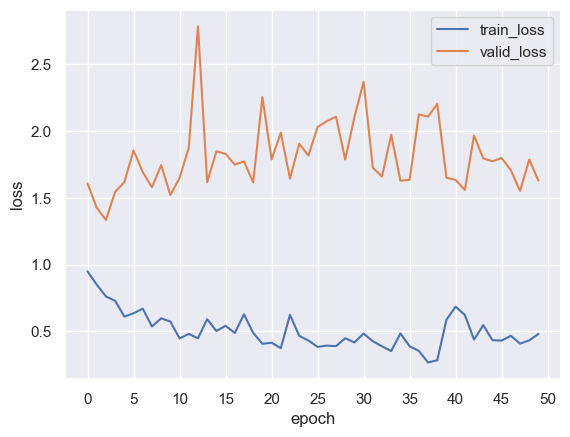

In [45]:
plot_loss(train_loss, valid_loss)

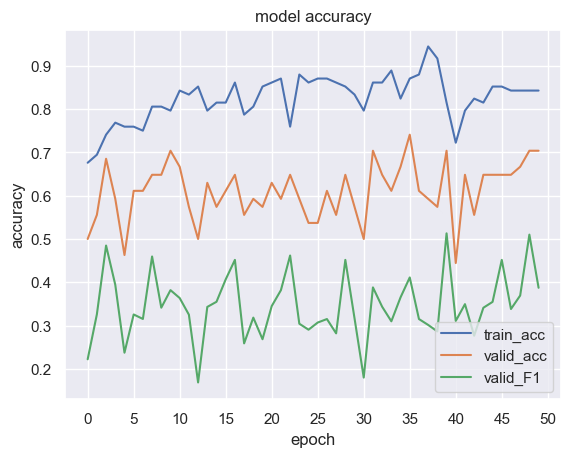

In [46]:
plot_metrics(train_acc, valid_acc, valid_f1)

In [47]:
print(f'accuracy: {max(valid_acc)}, f1 score: {max(valid_f1)}')

accuracy: 0.7407407407407407, f1 score: 0.512966476913346
